# Bi-elliptic transfer

This tutorial provides a practical example on how to solve a bi-elliptic transfer problem using Python.

## What is a bi-elliptic transfer?

A bi-elliptic transfer is an orbital maneuver used in spaceflight to transfer a spacecraft between two orbits using two half-elliptical orbits and three engine impulses. It is more fuel-efficient than a Hohmann transfer for certain orbital changes where the final orbit radius is significantly larger than the initial orbit radius.

The orbit transfer is typically modeled under the two-body assumption. This means that it assumes a simplified scenario where only two significant gravitational bodies are considered: the spacecraft and the central body (e.g., a planet or a moon).

## Problem statement

A satellite presents a circular and equatorial orbit with a periapsis radius of $6700$ kilometers. Propagate this parking orbit for $2$ hours. Next, apply a bi-elliptic transfer to raise the apoapsis radius first up to $80000$ km, and then achieve a final orbit with a periapsis radius of $42238$ km. Finally, propagate the new orbit for $1$ day.

Compute the required $\Delta v$ for each impulse of the maneuver.

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used in no_graphics mode. This means that the graphic user interface (GUI) of the product is not launched:

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Start by creating a new scenario in STK by running:

In [2]:
root = stk.new_object_root()
root.new_scenario("BiEllipticTransfer")

Once created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

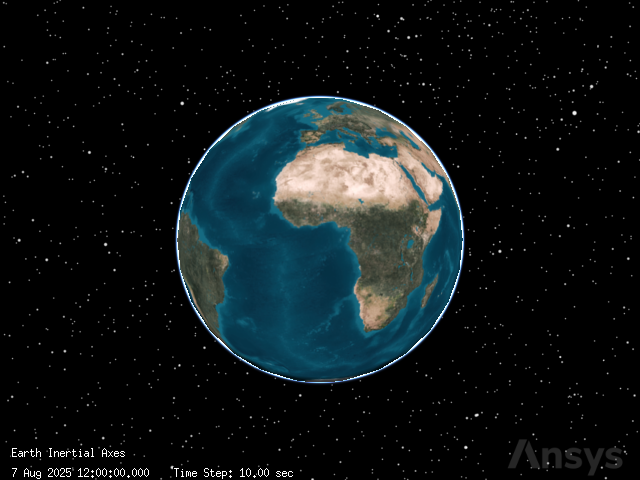

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


plotter = GlobeWidget(root, 640, 480)
plotter.show()

## Adding a satellite to the scenario

Now that a new scenario is available, add a new satellite:

In [4]:
from ansys.stk.core.stkobjects import STKObjectType


satellite = root.current_scenario.children.new(STKObjectType.SATELLITE, "Satellite")

Then, declare the type of orbit propagator used for the satellite:

In [5]:
from ansys.stk.core.stkobjects import PropagatorType


satellite.set_propagator_type(PropagatorType.ASTROGATOR)

Initialize the propagator by making sure that no previous sequence is present. Add any additional configurations for the propagator. For this example, it is requested to draw the maneuver in 3D.

In [6]:
satellite.propagator.main_sequence.remove_all()
satellite.propagator.options.draw_trajectory_in_3d = True

## Set up the initial state of the satellite

Start by adding a new segment to the main sequence for modeling the initial state of the satellite:

In [7]:
from ansys.stk.core.stkobjects.astrogator import SegmentType


initial_state = satellite.propagator.main_sequence.insert(
    SegmentType.INITIAL_STATE, "Initial State", "-"
)

A total of six orbital parameters are required to specify the initial state of the satellite. Considering the data provided in this example, Keplerian elements can be used. Thus, it is possible to assign the following parameters:

In [8]:
from ansys.stk.core.stkobjects.astrogator import ElementSetType


initial_state.set_element_type(ElementSetType.KEPLERIAN)

initial_state.element.periapsis_radius_size = 6700.00
initial_state.element.eccentricity = 0.00
initial_state.element.inclination = 0.00
initial_state.element.raan = 0.00
initial_state.element.arg_of_periapsis = 0.00
initial_state.element.true_anomaly = 0.00

## Propagate the parking orbit of the satellite

The parking orbit is the temporary orbit that the satellite follows before starting any maneuver. Modelling a parking orbit requires inserting a new `PROPAGATE` segment type in the main sequence. To be consistent with the assumptions of the bi-elliptic transfer, the segment should be propagated using an `Earth point mass` propagator. The total duration of the propagation is set for $7200$ seconds, that is $2$ hours.

In [9]:
parking_orbit_propagate = satellite.propagator.main_sequence.insert(
    SegmentType.PROPAGATE, "Parking Orbit Propagate", "-"
)
parking_orbit_propagate.propagator_name = "Earth point mass"
parking_orbit_propagate.stopping_conditions["Duration"].properties.trip = 7200

Additional configurations, like the color used to visualize the orbit of the satellite, can also be declared by running:

In [10]:
from ansys.stk.core.utilities.colors import Colors


parking_orbit_propagate.properties.color = Colors.Blue

## Set up the bi-elliptic transfer

The bi-elliptic transfer can be modelled as a sequence composed by five segments:


- **First impulse.** It is applied at the periapsis to raise the radius of apoapsis up to a desired value.
- **First propagation.** The satellite is propagated along its new elliptical transfer orbit until it reaches the apogee.
- **Second impulse.** It is applied at the apogee to change the periapsis to the final orbit's periapsis.
- **Second propagation.** The satellite is propagated along its second elliptical orbit until it reaches the final orbit.
- **Last impulse.** It is applied at the perigee of the final elliptical orbit to achieve a circular orbit.

A differential corrector is required for solving the first, second, and last impulses to achieve the desired apoapsis radius and periapsis radius. Therefore, these segments need to be modeled using a `TARGET_SEQUENCE` segment type. Regarding the propagation segments, these can be modeled using `PROPAGATION` segment types. All these segments can be collected under a `SEQUENCE` segment type.

All maneuvers are modeled as `IMPULSIVE` maneuver type. The attitude control used is of the type `THRUST_VECTOR`.

In [11]:
from ansys.stk.core.stkobjects.astrogator import AttitudeControl, ManeuverType


bielliptic_transfer = satellite.propagator.main_sequence.insert(
    SegmentType.SEQUENCE, "BiElliptic Transfer", "-"
)

bielliptic_start = bielliptic_transfer.segments.insert(
    SegmentType.TARGET_SEQUENCE, "BiElliptic Start", "-"
)
first_impulse = bielliptic_start.segments.insert(
    SegmentType.MANEUVER, "First Impulse", "-"
)
first_impulse.set_maneuver_type(ManeuverType.IMPULSIVE)
first_impulse.maneuver.set_attitude_control_type(AttitudeControl.THRUST_VECTOR)

first_propagate = bielliptic_transfer.segments.insert(
    SegmentType.PROPAGATE, "First Propagate", "-"
)
first_propagate.propagator_name = "Earth Point Mass"

bielliptic_middle = bielliptic_transfer.segments.insert(
    SegmentType.TARGET_SEQUENCE, "BiElliptic Middle", "-"
)
second_impulse = bielliptic_middle.segments.insert(
    SegmentType.MANEUVER, "Second Impulse", "-"
)
second_impulse.set_maneuver_type(ManeuverType.IMPULSIVE)
second_impulse.maneuver.set_attitude_control_type(AttitudeControl.THRUST_VECTOR)

second_propagate = bielliptic_transfer.segments.insert(
    SegmentType.PROPAGATE, "Second Propagate", "-"
)
second_propagate.propagator_name = "Earth Point Mass"

bielliptic_end = bielliptic_transfer.segments.insert(
    SegmentType.TARGET_SEQUENCE, "BiElliptic End", "-"
)
last_impulse = bielliptic_end.segments.insert(SegmentType.MANEUVER, "Last Impulse", "-")
last_impulse.set_maneuver_type(ManeuverType.IMPULSIVE)
last_impulse.maneuver.set_attitude_control_type(AttitudeControl.THRUST_VECTOR)

Finally, it is possible to visualize the segments layout of the bi-elliptic transfer sequence by running:

In [12]:
print(bielliptic_transfer.name)
for control_sequence in bielliptic_transfer.segments:
    try:
        print(f"\t{control_sequence.name}")
        for segment in control_sequence.segments:
            print(f"\t\t{segment.name}")
    except:
        continue

BiElliptic Transfer
	BiElliptic Start
		First Impulse
		-
	First Propagate
	BiElliptic Middle
		Second Impulse
		-
	Second Propagate
	BiElliptic End
		Last Impulse
		-
	-


### First impulse

Enable the component of the velocity impulse along the X axis as a control parameter. Add the radius of apoapsis as a result to be achieved.

In [13]:
from ansys.stk.core.stkobjects.astrogator import ControlManeuver


first_impulse.enable_control_parameter(ControlManeuver.IMPULSIVE_CARTESIAN_X)
first_impulse.results.add("Keplerian Elems/Radius of Apoapsis")

Now, configure the solver for this first impulse. A differential corrector can be used to solve for the values of the control parameters to achieved the desired results:

In [14]:
from ansys.stk.core.stkobjects.astrogator import ProfileMode


bielliptic_start_solver = bielliptic_start.profiles["Differential Corrector"]
bielliptic_start_solver.mode = ProfileMode.ITERATE
bielliptic_start_solver.max_iterations = 50

delta_v1_x = bielliptic_start_solver.control_parameters.get_control_by_paths(
    "First Impulse", "ImpulsiveMnvr.Cartesian.X"
)
delta_v1_x.enable = True
delta_v1_x.max_step = 0.30

desired_radius_of_apoapsis = bielliptic_start_solver.results.get_result_by_paths(
    "First Impulse", "Radius Of Apoapsis"
)
desired_radius_of_apoapsis.enable = True
desired_radius_of_apoapsis.desired_value = 80000.00
desired_radius_of_apoapsis.tolerance = 0.10

### First Propagation

After the first impulse, a propagation segment takes place in a bi-elliptic transfer. The stopping condition is imposed to take place at the apoapsis of the orbit:

In [15]:
first_propagate.stopping_conditions.add("Apoapsis")
first_propagate.stopping_conditions.remove("Duration")

This segment is colored using red to differentiate it from the parking segment:

In [16]:
first_propagate.properties.color = Colors.Red

### Second impulse

Again, enable the component of the velocity impulse along the X axis as a control parameter. Add the radius of periapsis as a result to be achieved.

In [17]:
second_impulse.enable_control_parameter(ControlManeuver.IMPULSIVE_CARTESIAN_X)
second_impulse.results.add("Keplerian Elems/Radius of Periapsis")
# Now, configure the solver for this second impulse. A differential corrector can be used to solve for the values of the control parameters to achieved the desired results:

In [18]:
bielliptic_middle_solver = bielliptic_middle.profiles["Differential Corrector"]
bielliptic_middle_solver.mode = ProfileMode.ITERATE
bielliptic_middle_solver.max_iterations = 50

delta_v2_x = bielliptic_middle_solver.control_parameters.get_control_by_paths(
    "Second Impulse", "ImpulsiveMnvr.Cartesian.X"
)
delta_v2_x.enable = True
delta_v2_x.max_step = 0.30

desired_radius_of_periapsis = bielliptic_middle_solver.results.get_result_by_paths(
    "Second Impulse", "Radius Of Periapsis"
)
desired_radius_of_periapsis.enable = True
desired_radius_of_periapsis.desired_value = 42238.00
desired_radius_of_periapsis.tolerance = 0.10

### Second Propagation

After the second impulse, another propagation segment takes place in a bi-elliptic transfer. The stopping condition is imposed to take place at the periapsis of the orbit:

In [19]:
second_propagate.stopping_conditions.add("Periapsis")
second_propagate.stopping_conditions.remove("Duration")

This segment is colored using yellow to differentiate it from the previous segments:

In [20]:
second_propagate.properties.color = Colors.Yellow

### Last impulse

Again, enable the component of the velocity impulse along the X axis as a control parameter. In this case, add the eccentricity as a result to be achieved.

In [21]:
last_impulse.enable_control_parameter(ControlManeuver.IMPULSIVE_CARTESIAN_X)
last_impulse.results.add("Keplerian Elems/Eccentricity")
# Now, configure the solver for this last impulse. A differential corrector can be used to solve for the values of the control parameters to achieved the desired results:

In [22]:
bielliptic_end_solver = bielliptic_end.profiles["Differential Corrector"]
bielliptic_end_solver.mode = ProfileMode.ITERATE
bielliptic_end_solver.max_iterations = 50

delta_v3_x = bielliptic_end_solver.control_parameters.get_control_by_paths(
    "Last Impulse", "ImpulsiveMnvr.Cartesian.X"
)
delta_v3_x.enable = True
delta_v3_x.max_step = 0.30

desired_eccentricity = bielliptic_end_solver.results.get_result_by_paths(
    "Last Impulse", "Eccentricity"
)
desired_eccentricity.enable = True
desired_eccentricity.desired_value = 0
desired_eccentricity.tolerance = 0.01

## Propagation along the final orbit

Once the last impulse has been applied, it is possible to propagate the satellite along its final orbit. Start by creating a new propagation segment in the main sequence. Propagate the satellite for a total of $86400$ seconds.

In [23]:
propagate_final_orbit = satellite.propagator.main_sequence.insert(
    SegmentType.PROPAGATE, "Final State Propagate", "-"
)
propagate_final_orbit.properties.color = Colors.Green
propagate_final_orbit.propagator_name = "Earth Point Mass"
propagate_final_orbit.stopping_conditions["Duration"].properties.trip = 86400.00

## Running the main control sequence

Once that all the segments for the main sequence are defined, the main control sequence can be executed to solve for the desired values in each sequence:

In [24]:
from ansys.stk.core.stkobjects.astrogator import TargetSequenceAction


bielliptic_start.action = TargetSequenceAction.RUN_ACTIVE_PROFILES
bielliptic_middle.action = TargetSequenceAction.RUN_ACTIVE_PROFILES
bielliptic_end.action = TargetSequenceAction.RUN_ACTIVE_PROFILES

satellite.propagator.run_mcs()

## Retrieve the results

Once the analysis has been performed, analytical results can be retrieved for a desired segment. The $\Delta v$ for each impulse along the x-direction are:

In [25]:
print(f"\N{GREEK CAPITAL LETTER DELTA}V1 = {delta_v1_x.final_value:.5f} [km/s]")
print(f"\N{GREEK CAPITAL LETTER DELTA}V2 = {delta_v2_x.final_value:.5f} [km/s]")
print(f"\N{GREEK CAPITAL LETTER DELTA}V3 = {delta_v3_x.final_value:.5f} [km/s]")

ΔV1 = 2.76494 [km/s]
ΔV2 = 0.97807 [km/s]
ΔV3 = -0.43323 [km/s]


## Apply the results

Previously computed results need to be applied to the main sequence. This can be done by running:

In [26]:
satellite.propagator.apply_all_profile_changes()

## Plot the trajectory

Finally, it is possible to visualize the complete sequence of maneuvers by showing the plotter again. Since the maneuver gets out of the field of view of the plotter's camera, the position of the camera is updated:

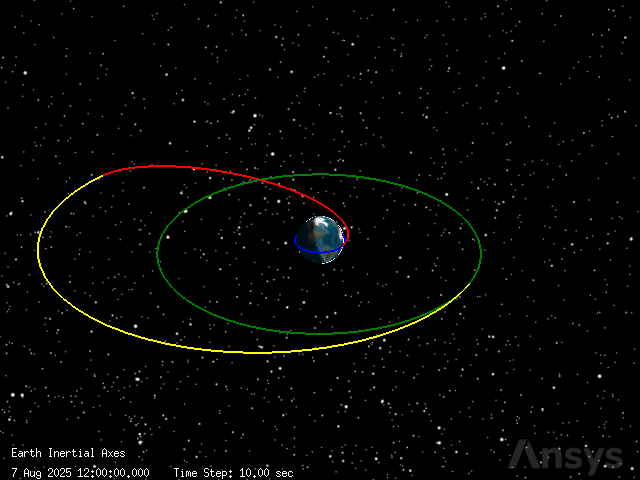

In [27]:
plotter.camera.position = [100000, 150000, 100000]
plotter.show()